In [8]:
# optimizer with scaling and lin reg

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('allRunsButOnlyTerran.csv')

# df = df[:1350]

dfTerranReg = df[df["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]

df2 = dfTerranReg#.sample(frac=0.45)

len(df2)


1058

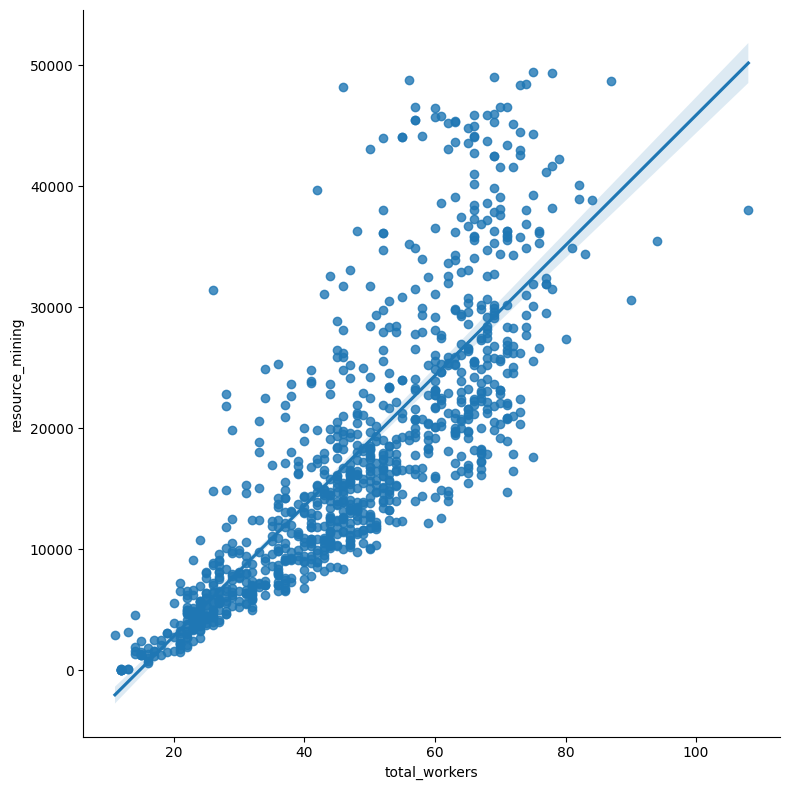

In [9]:
df2 = df2[df2["resource_mining"] < 50000]
custom_palette = ["#55a868", "#dd8452","#4c72b0"]
hue_order = ['Zerg', 'Protoss', 'Terraner']
g3= sns.lmplot(x="total_workers", y="resource_mining", order=1, palette=custom_palette,  data=df2,
          height=8)

In [10]:



X = df2[["total_workers"]]
y = df2["resource_mining"]

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

scaler = StandardScaler()
lin_reg = make_pipeline(scaler, LinearRegression())
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


The R^2 value in the test set is 0.5872854892780697


In [11]:



# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = df2.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army", "supply"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])
dfTerran


""
1
6
15
19
24
...
3554
3555
3556
3557


In [12]:

feats = dfTerran
feats = pd.concat([w, feats], axis=1)
feats


,total_workers
1,<gurobi.Var total_workers[1]>
6,<gurobi.Var total_workers[6]>
15,<gurobi.Var total_workers[15]>
19,<gurobi.Var total_workers[19]>
24,<gurobi.Var total_workers[24]>
...,...
3554,<gurobi.Var total_workers[3554]>
3555,<gurobi.Var total_workers[3555]>
3556,<gurobi.Var total_workers[3556]>
3557,<gurobi.Var total_workers[3557]>


In [13]:


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()


Model for pipe1:
1009 variables
2018 constraints
Input has shape (1009, 1)
Output has shape (1009, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
std_scaler1        (1009, 1)         1009         1009            0            0

lin_reg1           (1009, 1)            0         1009            0            0

--------------------------------------------------------------------------------
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5045 rows, 4036 columns and 11099 nonzeros
Model fingerprint: 0x48f763bc
Variable types: 2018 continuous, 2018 integer (0 binary)

In [14]:

outputs = pred_constr.input_values
pred_constr.input_values



,total_workers
1,48.0
6,48.0
15,48.0
19,48.0
24,48.0
...,...
3554,48.0
3555,48.0
3556,48.0
3557,48.0


In [15]:
# optimizer with scaling and mlp regressor

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')

df = df[:1350]

dfTerranReg = df[df["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]
X = dfTerranReg[["total_workers", "supply"]]
y = dfTerranReg["resource_mining"]


# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

feat_transform = make_column_transformer(
    (StandardScaler(), ["total_workers", "supply"]),
)

scaler = StandardScaler()
lin_reg = make_pipeline(feat_transform, MLPRegressor(random_state=1, max_iter=15000, learning_rate="adaptive"))
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


data = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')
data = data[1350:]

dfTerran = data[data["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]


# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = dfTerran.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)
s = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="supply", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])

feats = dfTerran
feats = pd.concat([w, feats], axis=1)


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()
outputs = pred_constr.input_values
outputs


FileNotFoundError: [Errno 2] No such file or directory: 'csv_dateien/starcraftFinalcsvs/stackedRunSup.csv'

In [ ]:

solution = pd.DataFrame()

solution["total_workers"] = w.gppd.X
solution["supply"] = dfTerran["supply"]

solution


,total_workers,supply
1350,0.0,165.0
1354,0.0,204.0
1357,55.0,31.0
1358,57.0,23.0
1359,37.0,101.0
...,...,...
3554,37.0,101.0
3555,39.0,93.0
3556,51.0,46.0
3557,15.0,125.0


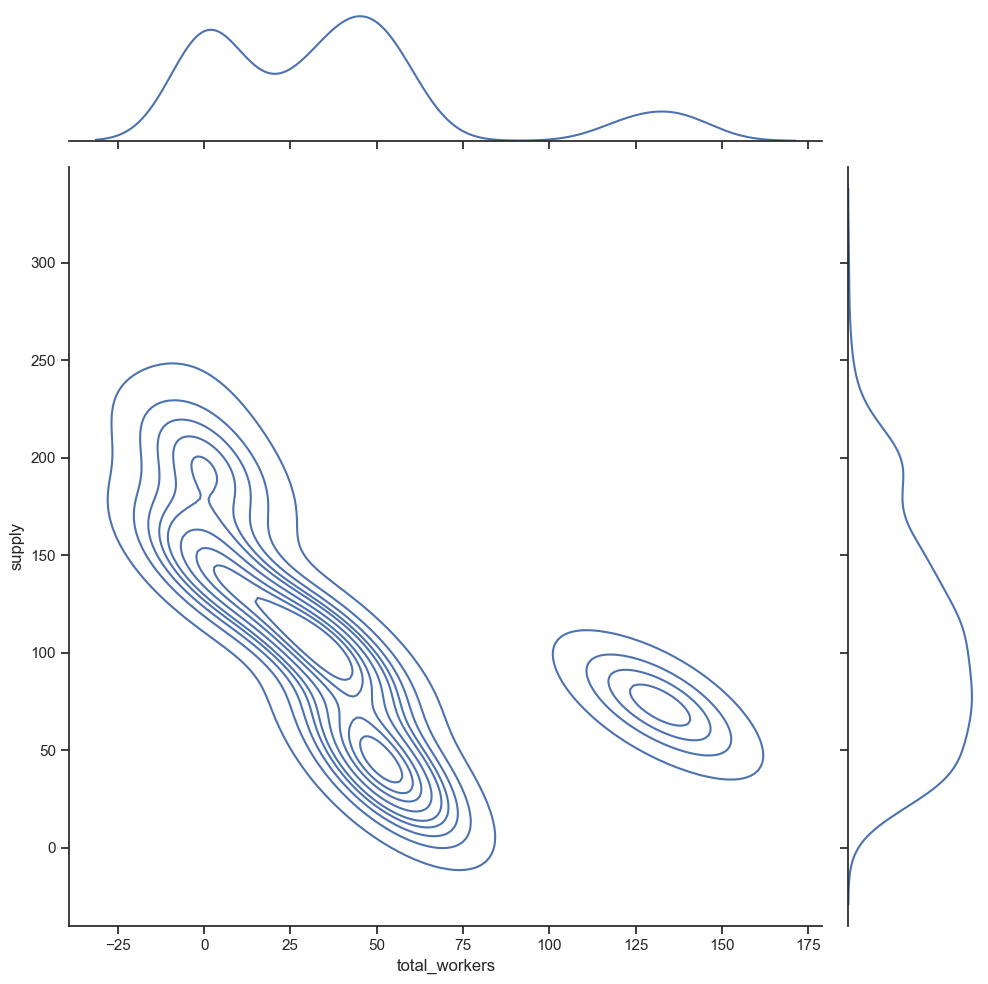

In [ ]:
custom_palette = ["#dd8452","#4c72b0",  "#55a868"]
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=solution, palette=custom_palette,
    x="total_workers", y="supply",  # ylim=[None, 150],
    kind="kde", height=10
)